# Пикник в Москве

## Intro

Что делают программисты? Правильно, они делают понятные вещи странными способами.

Смотрят в окно, например: https://www.isitdarkoutside.com

Попробуем узнать, где в Москве лучше всего устроить летний пикник.

Но вместо того, чтобы спрашивать друзей и гулять по окрестностям, попробуем сделать это аналитически.

In [8]:
import json
import numpy as np
import requests

## Получим данные

Документация: https://apidata.mos.ru/Docs

In [9]:
with open('./token.txt', 'r') as token:
    apiKey = token.read()

req_template = 'https://apidata.mos.ru/v1/{}/?api_key={}'

response = requests.get(req_template.format('datasets/912/rows', apiKey)) # это датасет про парки Москвы

In [10]:
data = response.json()

In [11]:
response, len(data)

(<Response [200]>, 156)

In [12]:
data[0]

{'Cells': {'Address': 'Алтуфьевское шоссе, дом 94',
  'AdmArea': 'Северо-Восточный административный округ',
  'ClarificationOfWorkingHoursWinter': None,
  'DimensionsWinter': [],
  'DisabilityFriendly': 'не приспособлен',
  'District': 'район Бибирево',
  'Email': 'leshoz_sewer@mail.ru',
  'EquipmentRentalComments': None,
  'HasCashMachine': 'нет',
  'HasDressingRoom': 'нет',
  'HasEatery': 'нет',
  'HasEquipmentRental': 'нет',
  'HasFirstAidPost': 'нет',
  'HasMusic': 'нет',
  'HasTechService': 'нет',
  'HasToilet': 'да',
  'HasWifi': 'нет',
  'HelpPhone': '(495) 579-29-76',
  'HelpPhoneExtension': None,
  'Lighting': 'без дополнительного освещения',
  'NameWinter': None,
  'ObjectName': 'Планируемый к созданию Комплексный заказник Алтуфьевский',
  'Paid': 'бесплатно',
  'PaidComments': None,
  'PhotoWinter': [],
  'Seats': 0,
  'ServicesWinter': [],
  'SurfaceTypeWinter': None,
  'TechServiceComments': None,
  'UsagePeriodWinter': None,
  'WebSite': 'www.dpioos.ru',
  'WorkingHoursWi

Отлично, у нас есть данные про 156 парков в таком формате

Сохраним это куда-нибудь.

In [13]:
with open('picnic.json', 'w') as f:
    json.dump(data, f)

## Изучим данные

In [14]:
picnic = [row['Cells'] for row in data]

print('Всего мест ', len(picnic))

Всего мест  156


In [24]:
picnic[0]

{'Address': 'Алтуфьевское шоссе, дом 94',
 'AdmArea': 'Северо-Восточный административный округ',
 'ClarificationOfWorkingHoursWinter': None,
 'DimensionsWinter': [],
 'DisabilityFriendly': 'не приспособлен',
 'District': 'район Бибирево',
 'Email': 'leshoz_sewer@mail.ru',
 'EquipmentRentalComments': None,
 'HasCashMachine': 'нет',
 'HasDressingRoom': 'нет',
 'HasEatery': 'нет',
 'HasEquipmentRental': 'нет',
 'HasFirstAidPost': 'нет',
 'HasMusic': 'нет',
 'HasTechService': 'нет',
 'HasToilet': 'да',
 'HasWifi': 'нет',
 'HelpPhone': '(495) 579-29-76',
 'HelpPhoneExtension': None,
 'Lighting': 'без дополнительного освещения',
 'NameWinter': None,
 'ObjectName': 'Планируемый к созданию Комплексный заказник Алтуфьевский',
 'Paid': 'бесплатно',
 'PaidComments': None,
 'PhotoWinter': [],
 'Seats': 0,
 'ServicesWinter': [],
 'SurfaceTypeWinter': None,
 'TechServiceComments': None,
 'UsagePeriodWinter': None,
 'WebSite': 'www.dpioos.ru',
 'WorkingHoursWinter': [],
 'geoData': {'coordinates': [3

In [15]:
latlon =  np.array([r['geoData']['coordinates'] for r in picnic])
print('Координаты:', *latlon[:3], "...")
convenience = [
        (
            int(r['HasWifi'] != 'нет'), 
            int(r['HasToilet'] != 'нет'), 
            int(r['Paid'] == 'бесплатно')
        ) 
        for r in picnic]
print('Удобства:', '...', *convenience[145:150], '...')


Координаты: [37.5962793  55.90387218] [37.62439579 55.6041267 ] [37.46735372 55.65470589] ...
Удобства: ... (0, 0, 1) (0, 0, 1) (0, 0, 1) (0, 0, 1) (0, 0, 1) ...


In [16]:
def topN(expected, data, N):
    norms = list(map(lambda row, number: (np.linalg.norm(row - expected), number), 
            data, range(len(data)) ))      # пары (расстояние, индекс)
    norms.sort(key=lambda r: r[0])         # рейтинг
    # множество индексов
    return set(map(lambda r: r[1], norms[:N]))

In [19]:
me_geo = np.array([37.740783, 55.687649])  # широта, долгота
me_conv = np.array([1.0, 1.0, 1.0])        # хочу всё: wifi, туалет и чтобы бесплатно!

depth = 1
A, B = set(), set()
# пока в пересечении ничего нет - расширяем поиск
while not A & B: 
    A = topN(me_geo, latlon, depth)
    B = topN(me_conv, convenience, depth)
    depth += 1
    
print('Мы рассматриваем {} ближайших и удобных мест. Самое интересное:'.format(depth))
for picnics in A & B:
    row = picnic[picnics]
    print(row['Address'])
    print('\tWifi: {}, WC: {}, Цена: {}'.format(row['HasWifi'], row['HasToilet'], row['Paid']))

Мы рассматриваем 19 ближайших и удобных мест. Самое интересное:
Липецкая улица, дом 10, корпус 2
	Wifi: да, WC: да, Цена: бесплатно


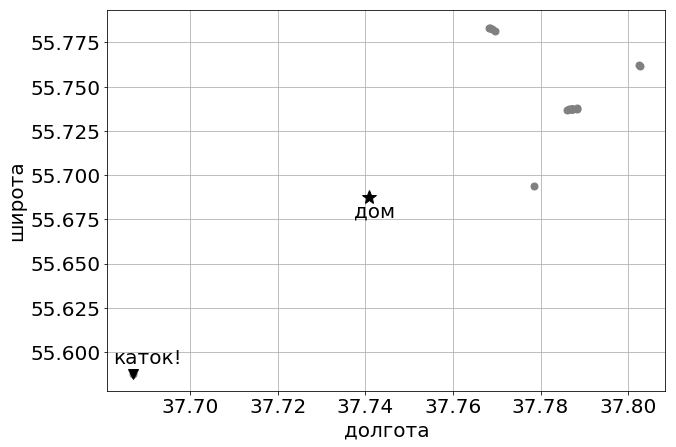

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 20})

closest = np.array([latlon[i] for i in A])
result = np.array([latlon[i] for i in A & B])
plt.figure(figsize=(10,7))
plt.plot(closest[:,0], closest[:,1], 'o', markersize=7, color='gray')
plt.plot(result[:,0], result[:,1], 'v', markersize=10, color='black')
plt.plot(*me_geo, '*', markersize=15, color='black')
plt.annotate('дом', xy=me_geo, xytext=(-15, -20), textcoords='offset points')
plt.annotate('каток!', xy=result[0], xytext=(-20, 10), textcoords='offset points')
plt.grid(True)
plt.xlabel('долгота')
plt.ylabel('широта')
plt.show()